# **DATA LOAD AND EDA PROCESS BEFORE MOVE FORWADING**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


app_logs_data= pd.read_csv("/content/app_logs.csv")

app_logs_data.head()

,timestamp,endpoint,user_id,response_time_ms,status_code
0,2024-12-01 23:20:31,/api/search,user_25,98,200
1,2024-12-01 23:25:31,/api/recommendations,user_82,107,200
2,2024-12-01 23:30:31,/api/chat,user_89,147,200
3,2024-12-01 23:35:31,/api/search,user_12,96,200
4,2024-12-01 23:40:31,/api/search,user_15,98,200


In [8]:
#Here timestamp not in the form of datetime object, we have to covert this firstly

app_logs_data['timestamp'] = pd.to_datetime(app_logs_data['timestamp'])

#1. Performance Analysis
#**Create functions to calculate key metrics:**

*   Average and p95 response times per endpoint
*   Error rates and types of errors
*   Peak usage periods
*   User experience metrics (e.g., % of requests > 1s)
*   Any additional metrics you think would be valuable












# **Average and p95 response times per endpoint**

In [30]:
def calculate_response_metrics(df):

    grouped_data = df.groupby('endpoint')['response_time_ms']
    Average_Response_time = grouped_data.mean()
    p95_Response_time = grouped_data.quantile(0.95)
    metrics = pd.DataFrame({
        'Average_Response_time': Average_Response_time,
        'P95_Response_time': p95_Response_time
    })
    return metrics

response_metrics_value = calculate_response_metrics(app_logs_data)
print(response_metrics_value)

                      Average_Response_time  P95_Response_time
endpoint                                                      
/api/chat                        445.026515             235.65
/api/recommendations             348.311871             155.20
/api/search                      471.608081             157.90
/api/user/profile                410.600806             160.00


#**Error rates and types of errors**

In [29]:
def calculate_Error_Rates(df):
    Total_Request = len(df)
    Error_Request = df[df['status_code'] >= 400]
    Error_Count = Error_Request.groupby('status_code').size()
    Error_Rate = (Error_Count / Total_Request) * 100
    return Error_Rate.sort_index(), Total_Request

Error_rate, Total_Request = calculate_Error_Rates(app_logs_data)
print(f"Total Requests: {Total_Request}")
print(Error_rate)

Total Requests: 2016
status_code
400    2.480159
500    2.579365
504    0.992063
dtype: float64


# **Peak usage periods**

In [28]:
def peak_usage(df):

    df['hour'] = df['timestamp'].dt.hour
    Hourly_Request_Count = df['hour'].value_counts()
    peak_usage = Hourly_Request_Count.sort_values(ascending=False)
    return peak_usage

Peak_Usage_value = peak_usage(app_logs_data)
print(Peak_Usage_value)


hour
23    84
0     84
1     84
2     84
3     84
4     84
5     84
6     84
7     84
8     84
9     84
10    84
11    84
12    84
13    84
14    84
15    84
16    84
17    84
18    84
19    84
20    84
21    84
22    84
Name: count, dtype: int64


#**User experience metrics (e.g., % of requests > 1s)**

In [34]:
def User_experience_metrics(df):
    #high_response_count = len(df[df['response_time_ms'] > 750])
    #high_response_count = len(df[df['response_time_ms'] > 950])
    high_response_count = len(df[df['response_time_ms'] > 1000
                                 ])
    percentage = (high_response_count / len(df)) * 100
    return percentage

User_experience_metrics_value = User_experience_metrics(app_logs_data)
print(User_experience_metrics_value)

0.992063492063492


# **Any additional metrics you think would be valuable**



*   Request per Seconds



In [35]:
def calculate_RPS(df):
    start_time = df['timestamp'].min()
    end_time = df['timestamp'].max()
    total_time_seconds = (end_time - start_time).total_seconds()
    RPS = len(df) / total_time_seconds
    return RPS

RPS_value = calculate_RPS(app_logs_data)
print(RPS_value)


0.0033349875930521094


#**2. Visualization Dashboard**

Create clear visualizations showing:

● Response time trends over time

● Error rate patterns

● Endpoint performance comparison

● Peak usage analysis



# **VISUALIZATION**

Visualization 1: **Response time trends over time**

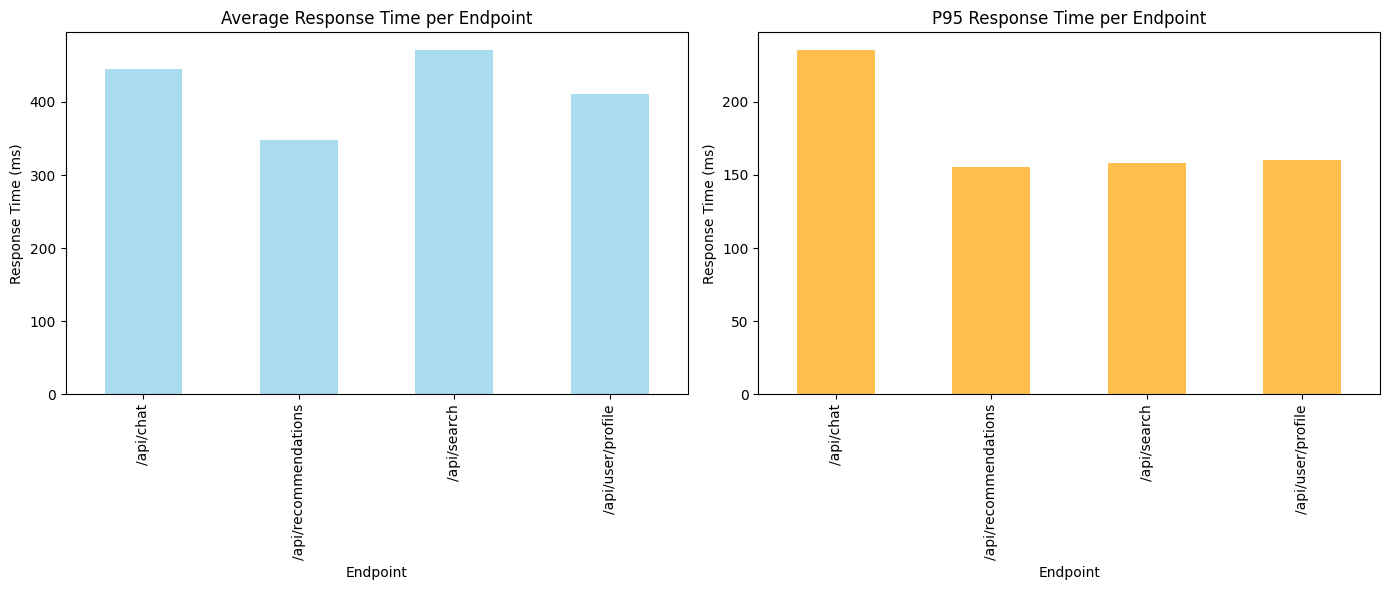

In [36]:

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
response_metrics_value['Average_Response_time'].plot(kind='bar', ax=ax[0], color='skyblue', alpha=0.7)
ax[0].set_title('Average Response Time per Endpoint')
ax[0].set_ylabel('Response Time (ms)')
ax[0].set_xlabel('Endpoint')

response_metrics_value['P95_Response_time'].plot(kind='bar', ax=ax[1], color='orange', alpha=0.7)
ax[1].set_title('P95 Response Time per Endpoint')
ax[1].set_ylabel('Response Time (ms)')
ax[1].set_xlabel('Endpoint')

plt.tight_layout()
plt.show()

V2 : **Error rate patterns**

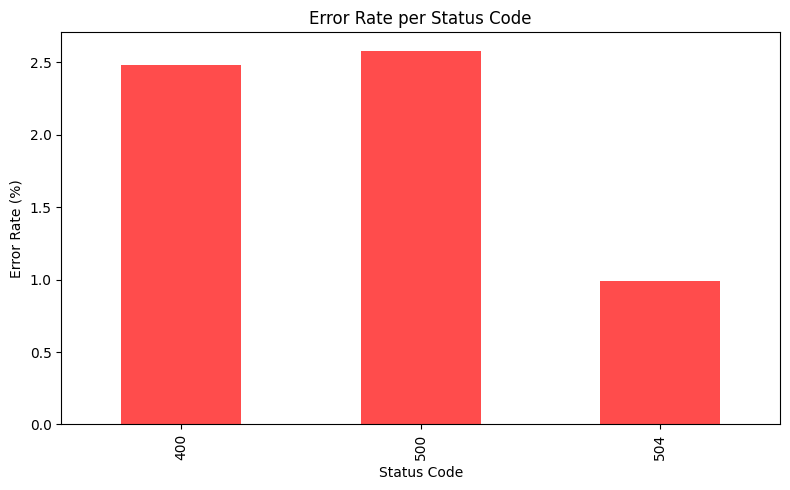

In [37]:

plt.figure(figsize=(8, 5))
Error_rate.plot(kind='bar', color='red', alpha=0.7)
plt.title('Error Rate per Status Code')
plt.xlabel('Status Code')
plt.ylabel('Error Rate (%)')
plt.tight_layout()
plt.show()


V 3: **User Experience Metrics**

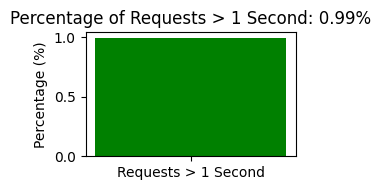

In [39]:

plt.figure(figsize=(3, 2))
plt.bar(['Requests > 1 Second'], [User_experience_metrics_value], color='green')
plt.title(f'Percentage of Requests > 1 Second: {User_experience_metrics_value:.2f}%')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

V4: **Peak Usage Analysis**

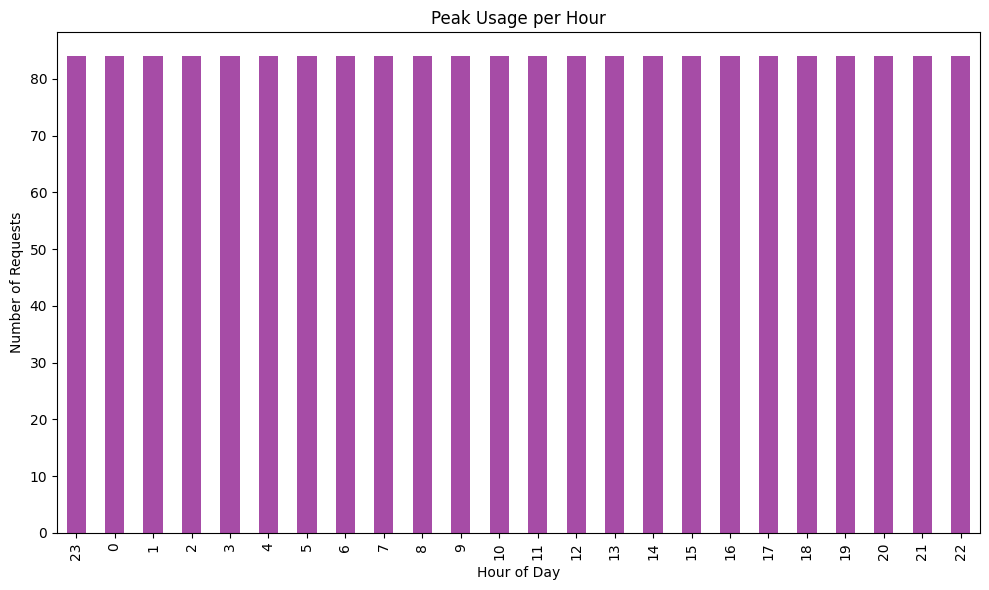

In [40]:

plt.figure(figsize=(10, 6))
Peak_Usage_value.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Peak Usage per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Requests')
plt.tight_layout()
plt.show()

#**3. Anomaly Detection**

Implement basic anomaly detection to identify:

● Unusual spikes in response time

● Error rate anomalies

● Endpoint availability issues


#**Unusual spikes in response time**

We Compare the response time to the mean and standard deviation - the Z-score. Where any response time above the threshold, mean + n * standard deviation is an anomaly.


In [44]:


def detect_response_time_spikes(df, threshold=3):
# Z-score > 3: The data point is more than 3 standard deviations away from the mean,
#which is often considered an outlier or an anomaly.
    # Calculate mean and standard deviation of response times
    mean_response_time = df['response_time_ms'].mean()
    std_response_time = df['response_time_ms'].std()

    # Z-score calculation: (value - mean) / std
    df['response_time_zscore'] = (df['response_time_ms'] - mean_response_time) / std_response_time

    # Detect spikes: where Z-score is above a certain threshold
    response_time_spikes = df[df['response_time_zscore'] > threshold]

    return response_time_spikes

# Detect spikes in response time
response_time_spikes = detect_response_time_spikes(app_logs_data)
print("Response Time Spikes:")
print(response_time_spikes)

Response Time Spikes:
               timestamp              endpoint  user_id  response_time_ms  \
33   2024-12-02 02:05:31     /api/user/profile  user_18             30000   
139  2024-12-02 10:55:31             /api/chat   user_6             30000   
142  2024-12-02 11:10:31  /api/recommendations  user_54             30000   
184  2024-12-02 14:40:31             /api/chat  user_88             30000   
219  2024-12-02 17:35:31           /api/search  user_40             30000   
360  2024-12-03 05:20:31  /api/recommendations  user_38             30000   
514  2024-12-03 18:10:31     /api/user/profile  user_53             30000   
744  2024-12-04 13:20:31           /api/search  user_82             30000   
863  2024-12-04 23:15:31     /api/user/profile  user_13             30000   
925  2024-12-05 04:25:31           /api/search  user_18             30000   
926  2024-12-05 04:30:31             /api/chat  user_67             30000   
1022 2024-12-05 12:30:31     /api/user/profile  user_3

#**Error rate anomalies**

For each hour, we calculate the error rate as the percentage of requests that resulted in errors (status code 4xx or 5xx).

We then compute a moving average of the error rates and their standard deviation.

If the error rate exceeds the moving average + n times the standard deviation, we classify it as an anomaly.

In [56]:
def detect_error_rate_anomalies(df, window_size=5
                                , threshold_factor=1):
    # moving average of the error rate
    df['hour'] = df['timestamp'].dt.hour
    total_requests_per_hour = df.groupby('hour').size()
    error_requests_per_hour = df[df['status_code'] >= 400].groupby('hour').size()

    error_requests_per_hour = error_requests_per_hour.reindex(total_requests_per_hour.index, fill_value=0)

    # error rate as a percentage
    error_rate_per_hour = (error_requests_per_hour / total_requests_per_hour) * 100

    print("Error rate per hour:\n", error_rate_per_hour)

    # Moving average
    error_rate_ma = error_rate_per_hour.rolling(window=window_size).mean()
    error_rate_std = error_rate_per_hour.rolling(window=window_size).std()

    # Debug: Check moving average and standard deviation
    print("Moving Average of Error Rate:\n", error_rate_ma)
    print("Standard Deviation of Error Rate:\n", error_rate_std)

    # Detect anomalies
    error_rate_anomalies = error_rate_per_hour[error_rate_per_hour > error_rate_ma + threshold_factor * error_rate_std]

    return error_rate_anomalies


error_rate_anomalies = detect_error_rate_anomalies(app_logs_data)
print("\nError Rate Anomalies:")
print(error_rate_anomalies)


Error rate per hour:
 hour
0      5.952381
1      3.571429
2      5.952381
3      3.571429
4      8.333333
5      3.571429
6      3.571429
7      5.952381
8      5.952381
9      8.333333
10     8.333333
11     2.380952
12     8.333333
13     3.571429
14    13.095238
15     5.952381
16     5.952381
17     4.761905
18    11.904762
19     7.142857
20     3.571429
21     3.571429
22     5.952381
23     5.952381
dtype: float64
Moving Average of Error Rate:
 hour
0          NaN
1          NaN
2          NaN
3          NaN
4     5.476190
5     5.000000
6     5.000000
7     5.000000
8     5.476190
9     5.476190
10    6.428571
11    6.190476
12    6.666667
13    6.190476
14    7.142857
15    6.666667
16    7.380952
17    6.666667
18    8.333333
19    7.142857
20    6.666667
21    6.190476
22    6.428571
23    5.238095
dtype: float64
Standard Deviation of Error Rate:
 hour
0          NaN
1          NaN
2          NaN
3          NaN
4     1.992048
5     2.129589
6     2.129589
7     2.129589
8  

Error Rate Anomalies:

hour

4        8.333333

9        8.333333

14      13.095238


 # **Endpoint availability issues**

 We count the number of requests per endpoint per hour.

If an endpoint's request count for a given hour is less than a **specified threshold** , it is considered an availability issue.

In [61]:
def detect_endpoint_availability_issues(df, threshold=0.8):
    df['hour'] = df['timestamp'].dt.hour
    request_count_per_hour = df.groupby(['hour', 'endpoint']).size().unstack(fill_value=0)
    # average requests per endpoint
    avg_requests_per_endpoint = request_count_per_hour.mean()

    # Detect availability issues
    issues = request_count_per_hour < (avg_requests_per_endpoint * threshold)

    return issues


endpoint_availability_issues = detect_endpoint_availability_issues(app_logs_data)

# Print availability issues
print("\nEndpoint Availability Issues:")
print(endpoint_availability_issues)


Endpoint Availability Issues:
endpoint  /api/chat  /api/recommendations  /api/search  /api/user/profile
hour                                                                     
0             False                 False        False              False
1             False                 False        False               True
2             False                 False        False              False
3              True                 False        False              False
4             False                 False        False              False
5             False                 False        False              False
6             False                 False        False              False
7             False                  True         True              False
8              True                 False        False              False
9              True                 False        False              False
10            False                 False         True              False
11     

**As we increased the threshold then chances of availabilty issues**